# Penalised Regression

We often do not want the coefficients/ weights to be too large. Hence we append the loss function with a penalty function to discourage large values of $w$.

\begin{align}
\mathcal{L} & = \sum_{i=1}^N (y_i-f(x_i,w,b))^2 + \alpha \sum_{j=1}^D w_j^2 + \beta \sum_{j=1}^D |w_j|
\end{align}

The values of $\alpha$ and $\beta$ are positive (or zero), with higher values enforcing the weights to be closer to zero.

In [3]:
import numpy as np
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
%matplotlib inline

Generate observations $y$ given feature (design) matrix $X$ according to:
$$
y = Xw + \xi\\
\xi_i \sim \mathcal{N}(0,\sigma^2)
$$

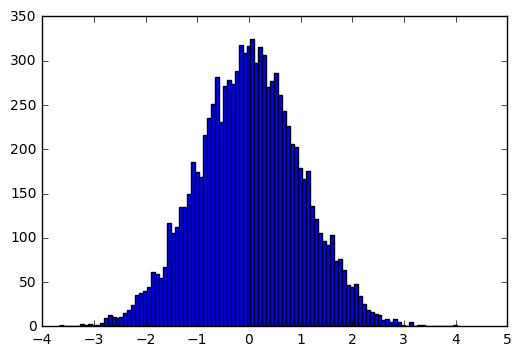

In [119]:
np.random.seed(1)

e = np.random.randn(10000,1)
plt.hist(e,100) #histogram with 100 bins
plt.show()

In [120]:
# Generate the data
N = 40 # Number of observations
D = 100 # Dimenstionality

x = np.random.randn(N,D) # get random observations of x
w_true = np.zeros((D,1)) # create a weight vector of zeros
idx = np.random.choice(100,10,replace=False) # randomly choose 10 of those weights
w_true[idx] = np.random.randn(10,1) # populate then with 10 random weights

e = np.random.randn(N,1) # have a noise vector
y = np.matmul(x,w_true) + e # generate observations

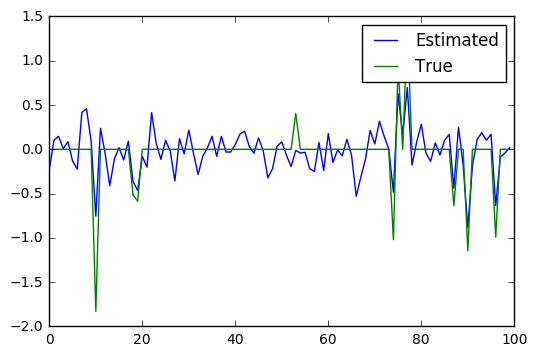

In [121]:
model = LinearRegression()
model.fit(x,y)

# plot the true vs estimated coeffiecients
plt.plot(np.arange(100),np.squeeze(model.coef_))
plt.plot(np.arange(100),w_true)
plt.legend(["Estimated","True"])
plt.show()

In [122]:
N_test = 50
x_test = np.random.randn(50,D)
y_test_true = np.matmul(x_test,w_true)

y_est = model.predict(x_test)
mse = np.mean(np.square(y_test_true-y_est))
print(mse)

6.78127324834


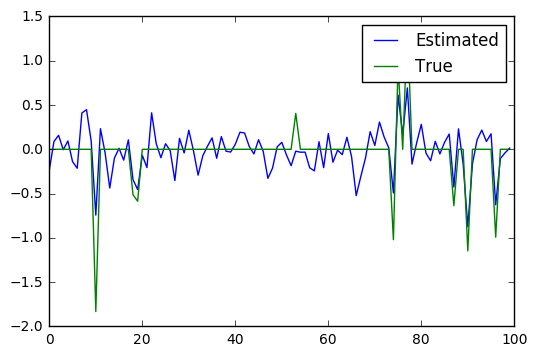

In [123]:
from sklearn.linear_model import Ridge

model = Ridge(alpha=1.0,fit_intercept = False)
model.fit(x,y)

# plot the true vs estimated coeffiecients
plt.plot(np.arange(100),np.squeeze(model.coef_))
plt.plot(np.arange(100),w_true)
plt.legend(["Estimated","True"])
plt.show()

In [124]:
y_est = model.predict(x_test)
mse = np.mean(np.square(y_test_true-y_est))
print(mse)

6.67707783253


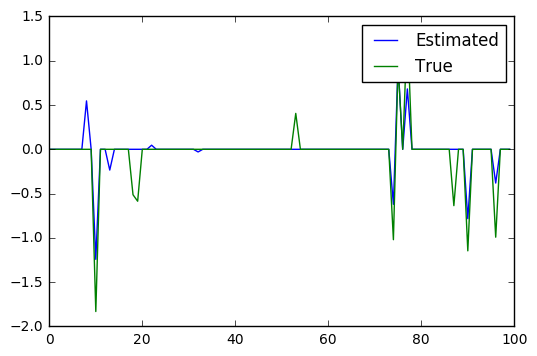

In [125]:
from sklearn.linear_model import Lasso

model = Lasso(alpha=0.5,fit_intercept = False)
model.fit(x,y)

# plot the true vs estimated coeffiecients
plt.plot(np.arange(100),np.squeeze(model.coef_))
plt.plot(np.arange(100),w_true)
plt.legend(["Estimated","True"])
plt.show()

In [126]:
y_est = model.predict(x_test)[:,None]
mse = np.mean(np.square(y_test_true-y_est))
print(mse)

3.04453162991


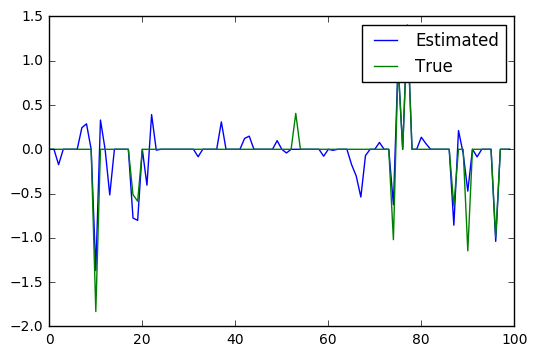

In [127]:
from sklearn.linear_model import ARDRegression

model = ARDRegression(fit_intercept = False)
model.fit(x,y.ravel())

# plot the true vs estimated coeffiecients
plt.plot(np.arange(100),np.squeeze(model.coef_))
plt.plot(np.arange(100),w_true)
plt.legend(["Estimated","True"])
plt.show()

In [128]:
y_est = model.predict(x_test)[:,None]
mse = np.mean(np.square(y_test_true-y_est))
print(mse)

2.87016718086


Rerun the above with setting N=400

## Inverse Problems

In [129]:
import numpy as np
from scipy import sparse
from scipy import ndimage
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt


def _weights(x, dx=1, orig=0):
    x = np.ravel(x)
    floor_x = np.floor((x - orig) / dx)
    alpha = (x - orig - floor_x * dx) / dx
    return np.hstack((floor_x, floor_x + 1)), np.hstack((1 - alpha, alpha))


def _generate_center_coordinates(l_x):
    X, Y = np.mgrid[:l_x, :l_x].astype(np.float64)
    center = l_x / 2.
    X += 0.5 - center
    Y += 0.5 - center
    return X, Y


def build_projection_operator(l_x, n_dir):
    """ Compute the tomography design matrix.

    Parameters
    ----------

    l_x : int
        linear size of image array

    n_dir : int
        number of angles at which projections are acquired.

    Returns
    -------
    p : sparse matrix of shape (n_dir l_x, l_x**2)
    """
    X, Y = _generate_center_coordinates(l_x)
    angles = np.linspace(0, np.pi, n_dir, endpoint=False)
    data_inds, weights, camera_inds = [], [], []
    data_unravel_indices = np.arange(l_x ** 2)
    data_unravel_indices = np.hstack((data_unravel_indices,
                                      data_unravel_indices))
    for i, angle in enumerate(angles):
        Xrot = np.cos(angle) * X - np.sin(angle) * Y
        inds, w = _weights(Xrot, dx=1, orig=X.min())
        mask = np.logical_and(inds >= 0, inds < l_x)
        weights += list(w[mask])
        camera_inds += list(inds[mask] + i * l_x)
        data_inds += list(data_unravel_indices[mask])
    proj_operator = sparse.coo_matrix((weights, (camera_inds, data_inds)))
    return proj_operator


def generate_synthetic_data():
    """ Synthetic binary data """
    rs = np.random.RandomState(0)
    n_pts = 36.
    x, y = np.ogrid[0:l, 0:l]
    mask_outer = (x - l / 2) ** 2 + (y - l / 2) ** 2 < (l / 2) ** 2
    mask = np.zeros((l, l))
    points = l * rs.rand(2, n_pts)
    mask[(points[0]).astype(np.int), (points[1]).astype(np.int)] = 1
    mask = ndimage.gaussian_filter(mask, sigma=l / n_pts)
    res = np.logical_and(mask > mask.mean(), mask_outer)
    return res - ndimage.binary_erosion(res)

/Users/sachin/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:64: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/sachin/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:68: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.


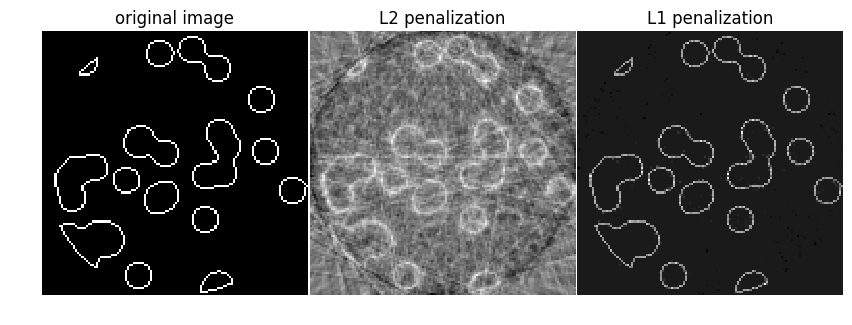

In [130]:
# Generate synthetic images, and projections
l = 128
proj_operator = build_projection_operator(l, l / 7.)
data = generate_synthetic_data()
proj = proj_operator * data.ravel()[:, np.newaxis]
proj += 0.15 * np.random.randn(*proj.shape)

# Reconstruction with L2 (Ridge) penalization
rgr_ridge = Ridge(alpha=0.2)
rgr_ridge.fit(proj_operator, proj.ravel())
rec_l2 = rgr_ridge.coef_.reshape(l, l)

# Reconstruction with L1 (Lasso) penalization
# the best value of alpha was determined using cross validation
# with LassoCV
rgr_lasso = Lasso(alpha=0.001)
rgr_lasso.fit(proj_operator, proj.ravel())
rec_l1 = rgr_lasso.coef_.reshape(l, l)

plt.figure(figsize=(8, 3.3))
plt.subplot(131)
plt.imshow(data, cmap=plt.cm.gray, interpolation='nearest')
plt.axis('off')
plt.title('original image')
plt.subplot(132)
plt.imshow(rec_l2, cmap=plt.cm.gray, interpolation='nearest')
plt.title('L2 penalization')
plt.axis('off')
plt.subplot(133)
plt.imshow(rec_l1, cmap=plt.cm.gray, interpolation='nearest')
plt.title('L1 penalization')
plt.axis('off')

plt.subplots_adjust(hspace=0.01, wspace=0.01, top=1, bottom=0, left=0,
                    right=1)

plt.show()